In [2]:
import pandas as pd
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pickle

import utils as u
from models import Poisson_Model_T, SafeMatern32_Model, All_Matern_Model, Poisson_Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set()
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100


%load_ext autoreload
%autoreload 2

In [3]:
data = pd.read_csv('../data/gp_weekly_nta_data.csv')
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

data.DATE_IND = data.DATE_IND.astype(float) / 100  # try to bring down variance scale
data.x_point = data.x_point.astype(float) / 100  # try to bring down variance scale
data.y_point = data.y_point.astype(float) / 100  # try to bring down variance scale

data.rename(columns={'INJURED':'COUNT'},inplace=True)

data.COUNT = data.COUNT.astype(float)

data = data[data.BoroName == 'Manhattan']

e_s = data[data.DATETIME < '2013-01-01'].e_s.mean()

print(e_s)

7.34046141428


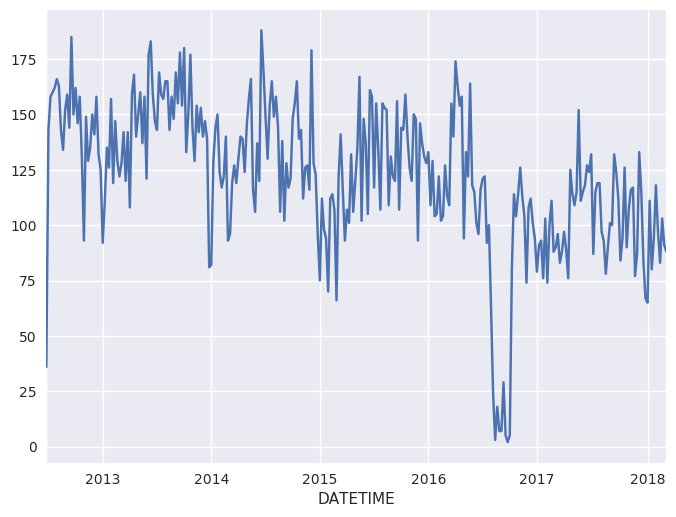

In [4]:
data.groupby('DATETIME')['COUNT'].sum().plot()

In [5]:
search_periods = [[52,26]]

In [ ]:
## NOTE: PoissonT: 2rbfs run for 2k+ iters with no priors

for i, s in enumerate(search_periods):
    
    print('Beginning run {} : '.format(str(s)))
    #print('{} periods for training \n').format(s[0])
    #print('{} periods for testing \n').format(s[1])

    data_dict = u.preprocess(data, start_date= '2013/1/06', training_end_date= s[0], \
                                                           testing_end_date=s[1])


    m =  Poisson_Model_T(data_dict['X_train'],data_dict['y_train'],use_priors=False, e_s = e_s , period = 1)
    m.compile()
    opt = gpflow.train.ScipyOptimizer()
    print('Initial neg. log-likelihood: {}'.format(str(m.compute_log_likelihood())))
    opt.minimize(m, maxiter = 3000)
    
    u.pred_GP(m,data_dict)
    test = data_dict['test']

    gp = test.groupby('DATETIME')['gp_sq_error'].mean() #/ test.GRID_SQUARE.max()
    ar = u.run_AR(data_dict)
    ar = ar 
    summary = pd.concat([gp,ar],axis=1)
    summary.plot()

    print(summary.mean())


Beginning run [52, 26] : 
Training ends on: 2014-01-05 00:00:00
testing ends on: 2014-07-06 00:00:00
Initial neg. log-likelihood: -77493.6820171


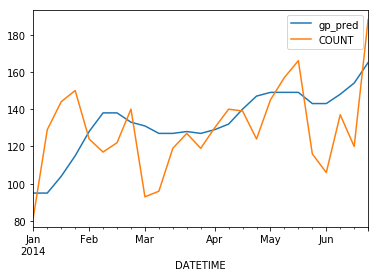

In [170]:
test.groupby('DATETIME')[['gp_pred','COUNT']].sum().plot()


In [171]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
VGP/kern/periodic/lengthscales,Parameter,None,+ve,True,(),True,0.14482649554304433
VGP/kern/periodic/period,Parameter,None,+ve,True,(),True,0.534288264998765
VGP/kern/periodic/variance,Parameter,None,+ve,True,(),True,0.023407251849601844
VGP/kern/rbf_2/lengthscales,Parameter,None,+ve,True,(),True,0.003310854281038125
VGP/kern/rbf_2/variance,Parameter,None,+ve,True,(),True,0.2863491835616518
VGP/kern/rbf_1/lengthscales,Parameter,None,+ve,True,(),True,1.1521709463311938
VGP/kern/rbf_1/variance,Parameter,None,+ve,True,(),True,0.3518888642689347
VGP/kern/rbf_2/lengthscales,Parameter,None,+ve,True,(),True,0.003310854281038125
VGP/kern/rbf_2/variance,Parameter,None,+ve,True,(),True,0.2863491835616518
VGP/kern/rbf_1/lengthscales,Parameter,None,+ve,True,(),True,1.1521709463311938


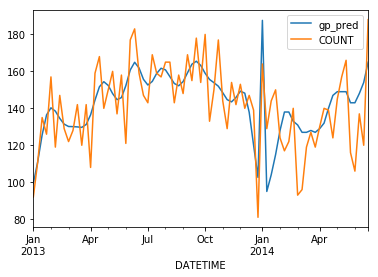

In [172]:
pred_train = m.predict_y(data_dict['X_train'])
train = data_dict['train']
train['gp_pred'] = pred_train[0]
test = data_dict['test']
train.append(test).groupby("DATETIME")['gp_pred','COUNT'].sum().plot()



## This needs:
# train/test normalization has to be split
# prediction has to be done right when looking ahead (sequentially)


In [173]:
X = np.vstack((data_dict['X_train'],(data_dict['X_test']) ))
y = np.vstack((data_dict['y_train'],(data_dict['y_test']) ))
df = pd.concat([data_dict['train'],data_dict['test']],axis = 0)

df['f_pred'] = m.predict_f(X)[0] 
df['y_pred'] = m.predict_y(X)[0] 
df['exp_f_pred'] = np.exp(df['f_pred'])

In [174]:
df.groupby('NTAName')['exp_f_pred'].mean().to_csv('files/MN_nta_f_pred.csv')

In [188]:
df.drop_duplicates( subset=['NTAName','DATE_IND'], inplace=True)

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


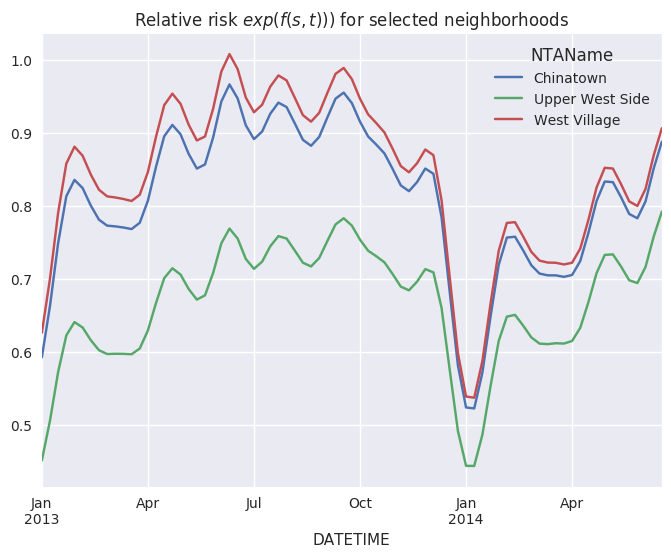

In [218]:
risk_ts = df.groupby(['NTAName','DATETIME'])[['f_pred','exp_f_pred','y_pred','COUNT']].mean()
risk_ts['real_f'] = np.log(risk_ts.COUNT / e_s)
risk_ts.loc[['West Village','Chinatown','Upper West Side','Inwood']]['exp_f_pred'].unstack(-1).T.plot()

plt.title('Relative risk $exp(f(s,t))$) for selected neighborhoods')

In [117]:
np.square(test.gp_pred - test.COUNT).groupby('DATETIME').mean()

DATETIME
2014-01-05     4.034483
2014-01-12     9.793103
2014-01-19    14.068966
2014-01-26     7.620690
2014-02-02     4.000000
2014-02-09     8.586207
2014-02-16     2.896552
2014-02-23     7.896552
2014-03-02     4.896552
2014-03-09     7.448276
2014-03-16     5.517241
2014-03-23     3.689655
2014-03-30     6.448276
2014-04-06     6.655172
2014-04-13     8.068966
2014-04-20     5.275862
2014-04-27     5.482759
2014-05-04     2.965517
2014-05-11     8.620690
2014-05-18    10.931034
2014-05-25     6.586207
2014-06-01     5.413793
2014-06-08     6.392857
2014-06-15     7.034483
2014-06-22    15.000000
dtype: float64

In [118]:

output = pd.DataFrame(index=test.index, columns=['pred','seed'])

output.ix[0,'seed'] = m.predict_f([data_dict['X_train'][-1]])[0]

for i in range(output.shape[0]):
    output.ix[i+1,'pred'] = m.predict_y([output.ix[0,'seed'][0]])


                                       
    if i > 0:
        m.predict_f([output.ix[i,'seed']])[0]

output


/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


ValueError: Cannot feed value of shape (1,) for Tensor 'autoflow/VGP/predict_f/Placeholder:0', which has shape '(?, ?)'

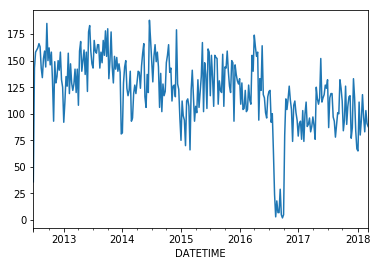

In [119]:
## Missing data 2016

data.groupby('DATETIME')['COUNT'].sum().plot()

In [120]:
test.groupby('GRID_SQUARE')['COUNT'].sum().sort_values(ascending = False).head()

GRID_SQUARE
108    308.0
85     252.0
51     204.0
151    181.0
30     179.0
Name: COUNT, dtype: float64

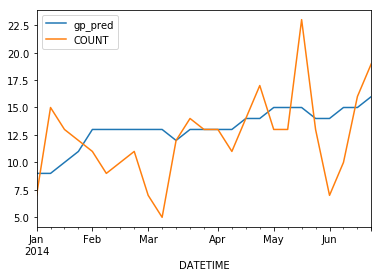

In [121]:
test[test.GRID_SQUARE == 108][['gp_pred','COUNT']].plot()